# DoorDash Delivery Time Prediction

# Question
The time spent by the user from placing an order to receiving food is composed of several parts, which can be expressed by the following formula:
$$
T = T_p + T_s + T_d
$$

- $T$: Total time
- $T_p$: Place time
- $T_s$: Time in shop
- $T_d$: Driving time 

$$
T_s = T_{sw} + T_{sp} + T_{sd}
$$

- $T_{sw}$: Wait time of order to be processed
- $T_{sp}$: Process time of food
- $T_{sd}$: Wait time for dasher pickup

We can assume:
 - $T_p$ = `estimated_order_place_duration`
 - $T_{d}$ = `estimated_store_to_consumer_driving_duration`

The model prediction target is: $T_s$

# Data

In [1]:
import pandas as pd
import numpy as np

def parse_datetime(dt):
    return pd.to_datetime(dt, utc=True).map(lambda x: x.tz_convert('US/Pacific'))

def load_dataset(name, predict=False):
    df = pd.read_csv(name)
    df.created_at = parse_datetime(df.created_at)
    if not predict:
        df.actual_delivery_time = parse_datetime(df.actual_delivery_time)
        df['delivery_duration'] = (df.actual_delivery_time - df.created_at) / np.timedelta64(1, 'm')
    for c in ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']:
        df[c] = df[c] / 60
    return df

df = load_dataset('historical_data.csv')
predict_df = load_dataset('predict_data.csv', predict=True)

In [2]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,197421.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,5.142670,9.089316,48.470956
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,1.502328,3.655882,320.493482
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.683333
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,4.183333,6.366667,35.066667
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,4.183333,9.066667,44.333333
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,7.433333,11.700000,56.350000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,45.250000,34.800000,141947.650000


In [3]:
df.isnull().sum(axis=0) / df.shape[0]

market_id                                       0.004999
created_at                                      0.000000
actual_delivery_time                            0.000035
store_id                                        0.000000
store_primary_category                          0.024110
order_protocol                                  0.005040
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           0.082369
total_busy_dashers                              0.082369
total_outstanding_orders                        0.082369
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.002664
delivery_duration                               0.000035
dtype: float64

In [4]:
predict_df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id
count,54528.000000,54778.000000,54495.000000,54778.000000,54778.000000,54778.000000,54778.000000,54778.000000,50145.000000,50145.000000,50145.000000,54778.000000,54767.000000,54778.000000
mean,3.031360,3489.640969,2.885017,3.227737,2715.758772,2.691902,683.757384,1166.795356,49.076179,43.515206,62.566756,5.135211,9.129423,126118.103454
std,1.531606,2050.221801,1.512087,2.557472,1897.919808,1.650204,538.496995,574.594726,37.594714,34.051339,56.378953,1.482298,3.674329,72683.611935
min,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,-63.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,0.000000,20.000000
25%,2.000000,1661.000000,1.000000,2.000000,1420.000000,2.000000,299.000000,819.000000,19.000000,16.000000,19.000000,4.183333,6.416667,62938.500000
50%,3.000000,3518.000000,3.000000,3.000000,2220.000000,2.000000,595.000000,1095.000000,41.000000,36.000000,45.000000,4.183333,9.066667,126194.000000
75%,4.000000,5247.000000,4.000000,4.000000,3415.000000,3.000000,929.000000,1399.000000,71.000000,63.000000,91.000000,7.433333,11.716667,188916.000000
max,6.000000,6986.000000,7.000000,81.000000,29925.000000,19.000000,25040.000000,25142.000000,175.000000,169.000000,292.000000,18.250000,25.833333,252031.000000


In [5]:
predict_df.isnull().sum(axis=0) / predict_df.shape[0]

market_id                                       0.004564
created_at                                      0.000000
store_id                                        0.000000
store_primary_category                          0.024517
order_protocol                                  0.005166
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           0.084578
total_busy_dashers                              0.084578
total_outstanding_orders                        0.084578
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.000201
delivery_id                                     0.000000
platform                                        0.000000
dtype: float64

In [6]:
df.created_at.min(), df.created_at.max()

(Timestamp('2014-10-18 22:24:15-0700', tz='US/Pacific'),
 Timestamp('2015-02-17 22:00:44-0800', tz='US/Pacific'))

In [7]:
predict_df.created_at.min(), predict_df.created_at.max()

(Timestamp('2015-02-18 06:50:28-0800', tz='US/Pacific'),
 Timestamp('2015-02-24 21:59:49-0800', tz='US/Pacific'))

In [8]:
df.nunique()

market_id                                            6
created_at                                      180985
actual_delivery_time                            178110
store_id                                          6743
store_primary_category                              74
order_protocol                                       7
total_items                                         57
subtotal                                          8368
num_distinct_items                                  20
min_item_price                                    2312
max_item_price                                    2652
total_onshift_dashers                              172
total_busy_dashers                                 159
total_outstanding_orders                           281
estimated_order_place_duration                      98
estimated_store_to_consumer_driving_duration      1336
delivery_duration                                 7134
dtype: int64

In [9]:
predict_df.nunique()

market_id                                           6
created_at                                      49941
store_id                                         5676
store_primary_category                             71
order_protocol                                      7
total_items                                        46
subtotal                                         6044
num_distinct_items                                 19
min_item_price                                   1729
max_item_price                                   1929
total_onshift_dashers                             175
total_busy_dashers                                172
total_outstanding_orders                          272
estimated_order_place_duration                      5
estimated_store_to_consumer_driving_duration     1241
delivery_id                                     54768
platform                                            3
dtype: int64

## Time Slot
Considering the timeliness of features, divide the time of day into multiple time periods. At present, it is divided into equal intervals.

In [10]:
TIME_SLOT_INVERTAL = 15

def date_to_time_slot(date, interval=TIME_SLOT_INVERTAL):
    return (date.hour * 60 + date.minute) // interval

df['date'] = df.created_at.apply(lambda x: x.date)
predict_df['date'] = predict_df.created_at.apply(lambda x: x.date)


df['day_of_week'] = df.created_at.apply(lambda x: x.dayofweek)
predict_df['day_of_week'] = predict_df.created_at.apply(lambda x: x.dayofweek)

df['hour'] = df.created_at.apply(lambda x: x.hour)
predict_df['hour'] = predict_df.created_at.apply(lambda x: x.hour)

df['time_slot'] = df.created_at.apply(date_to_time_slot)
predict_df['time_slot'] = predict_df.created_at.apply(date_to_time_slot)

<AxesSubplot:xlabel='day_of_week,time_slot'>

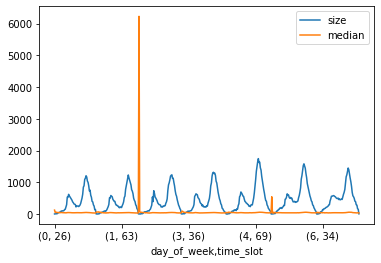

In [11]:
df.groupby(['day_of_week', 'time_slot'])['delivery_duration'].agg([np.size, np.median]).plot()

<AxesSubplot:xlabel='day_of_week,time_slot'>

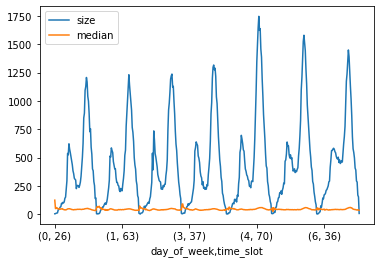

In [12]:
df[df.delivery_duration < 500].groupby(['day_of_week', 'time_slot'])['delivery_duration'].agg([np.size, np.median]).plot()

<AxesSubplot:xlabel='date'>

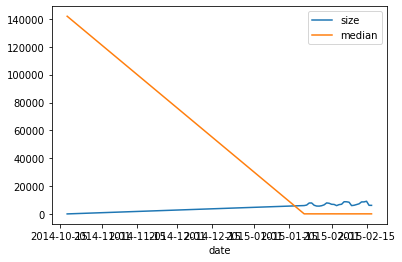

In [13]:
dates = df.groupby(['date'])['delivery_duration'].agg([np.size, np.median])
dates.plot()

In [14]:
dates

,size,median
date,,
2014-10-18,1.0,141947.650000
2015-01-21,5997.0,41.800000
2015-01-22,6356.0,41.708333
2015-01-23,7831.0,47.316667
2015-01-24,7861.0,46.100000
2015-01-25,6219.0,37.600000
2015-01-26,5645.0,42.133333
2015-01-27,5602.0,40.883333
2015-01-28,5888.0,41.383333


## Fix Invalid Data

In [15]:
def fix_invalid_data(df):
    df.loc[~(df.total_items >= 1), 'total_items'] = 1
    df.loc[~(df.num_distinct_items >= 1), 'num_distinct_items'] = 1
    df.loc[~(df.subtotal >= 0), 'subtotal'] = np.nan
    df.loc[~(df.min_item_price >= 0), 'min_item_price'] = 0
    df.loc[~(df.max_item_price >= 0), 'max_item_price'] = np.nan
    df.loc[~(df.total_onshift_dashers >= 0), 'total_onshift_dashers'] = np.nan
    df.loc[~(df.total_busy_dashers >= 0), 'total_busy_dashers'] = np.nan
    df.loc[~(df.total_outstanding_orders >= 0), 'total_outstanding_orders'] = np.nan
    df.loc[~(df.estimated_order_place_duration >= 0), 'estimated_order_place_duration'] = np.nan
    df.loc[~(df.estimated_store_to_consumer_driving_duration >= 0), 'estimated_store_to_consumer_driving_duration'] = np.nan

fix_invalid_data(df)
fix_invalid_data(predict_df)

df = df[df.delivery_duration < 600]


## Fix Null Data

In [169]:
def most_freq_value(a):
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

def column_value_aggs(df, col, parents, agg_func):
    if not parents:
        parents = []
    df = df[~df[col].isnull()]
    aggs = [df.groupby(parents[:i+1])[col].agg(agg_func) for i in range(len(parents))]
    default = agg_func(df[col])
    aggs.append(default)
    return aggs

def replace_na(x, y):
    return y if pd.isnull(x) else x
    
def column_fill_null_with_aggs(df, col, aggs):
    if df[col].isnull().size == 0:
        return df
    for agg in aggs[:-1]:
        df = df.join(agg, on=agg.index.names, how='left', lsuffix='', rsuffix='_')
        df[col] = df.apply(lambda row: replace_na(row[col], row[col + '_']), axis=1)
        df = df.drop(col+ '_', axis=1)
        if df[col].isnull().size == 0:
            return df
    default = aggs[-1]
    df[col].fillna(default)
    return df

def column_fill_null(df, predict_df, col, parents=None, agg_func=most_freq_value):
    aggs = column_value_aggs(df, col, parents, agg_func)
    df = column_fill_null_with_aggs(df, col, aggs)
    predict_df = column_fill_null_with_aggs(predict_df, col, aggs)
    return df, predict_df

In [17]:
cols = ['market_id', 'store_id', 'store_primary_category', 'order_protocol']
for i, c in enumerate(cols):
    df, predict_df = column_fill_null(df, predict_df, c, cols[:i])

parents = ['market_id', 'store_primary_category', 'store_id', 'hour', 'time_slot']
values = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]

for c in values:
    df, predict_df = column_fill_null(df, predict_df, c, parents, agg_func=np.median)

## Fix Categorical Data

In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
all_category = pd.concat([df.store_primary_category, predict_df.store_primary_category])
le.fit(all_category)
df.store_primary_category = le.transform(df.store_primary_category)
predict_df.store_primary_category = le.transform(predict_df.store_primary_category)

types = {col: 'int64' for col in ['market_id', 'store_id', 'order_protocol']}
df = df.astype(types)
predict_df = predict_df.astype(types)

In [98]:
df.to_csv('history.csv')
predict_df.to_csv('predict.csv')

df.to_pickle('history.pkl')
predict_df.to_pickle('predict.pkl')

# Model

## Loss function

- Problem setting
  - Order lateness/underprediction of delivery time is of particular concern as past experiments suggest that underestimating delivery time is roughly twice as costly as overestimating it.
  - Orders that are very early/late are also much worse than those that are only slightly early/late.

In order to meet the problem setting and robustness requirements, the selected loss function is as follows:
$$
\begin{align}
loss(real, pred) &= 
\begin{cases}
real - pred & \text{if real - pred $\ge$ 0} \\
0.5 * (pred - real) & \text{else}
\end{cases} \\
&= 0.75 * |real - pred| + 0.25 * (real - pred)
\end{align}
$$

In [49]:
import scipy as sp

def loss_func(real, pred):
    d = real - pred
    return 0.75 * np.abs(d) + 0.25 * d

def compute_metrics(real, pred):
    return sp.stats.describe(loss_func(real, pred))

## Baseline Model

First use xgboost to establish a baseline model.

Since $|x|$ is first-order and second-order not differentiable, we use the $h(x; \theta)$ approximation.
$$
h(x; \theta) = \int_0^x{\frac{x}{\sqrt{1+{(\frac{x}{\theta})}^2}}} dx
$$

In order to reduce the error caused by the function approximation, we can correct the output of xgboost.

In [246]:
def huber_approx_obj(y_true, y_pred, theta):
    d = y_pred - y_true
    scale = 1 + (d / theta) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

def approx_loss_obj(y_true, y_pred, theta=1.0):
    grad, hess = huber_approx_obj(y_true, y_pred, theta)
    return 0.75 * grad + 0.25, 0.75 * hess

In [247]:
import xgboost as xgb
import cvxpy as cp

def baseline_model(X, y, obj=approx_loss_obj, learning_rate=0.01, max_depth=4):
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        objective=obj,
    )
    model.fit(X, np.expand_dims(y, axis=1))
    
    # adjust xgboost predict
    y_pred = model.predict(X)
    delta = cp.Variable(1)
    d = y - (y_pred + delta)

    cost = cp.sum(0.75 * cp.abs(d) + 0.25 * d)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    delta = delta.value
    return [model, delta]

def baseline_predict(X, model):
    m, delta = model
    return m.predict(X) + delta


In [248]:
df = pd.read_pickle('history.pkl')
predict_df = pd.read_pickle('predict.pkl')

df['estimated_in_store_duration'] = df['delivery_duration'] - df['estimated_order_place_duration'] - df['estimated_store_to_consumer_driving_duration']
predict_df['estimated_in_store_duration'] = np.nan

In [189]:
from sklearn.model_selection import train_test_split

def train(df, features):
    X = df[features].values
    y = df.estimated_in_store_duration.values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=11)

    best_validate_loss = None
    results = []
    for max_depth in range(10, 20):
        model = baseline_model(X_train, y_train, max_depth=max_depth)
        train_metrics = compute_metrics(y_train, baseline_predict(X_train, model))
        validate_metrics = compute_metrics(y_validate, baseline_predict(X_validate, model))
        results.append([max_depth, train_metrics.mean, validate_metrics.mean])
        print(results[-1])
        if best_validate_loss is not None and validate_metrics.mean > best_validate_loss:
            break
        else:
            best_validate_loss = validate_metrics.mean
    results = pd.DataFrame(results, columns=['max_depth', 'train', 'validate'])
    opt_max_depth = int(results.max_depth[np.argmin(results.validate)])
    model = baseline_model(X_train, y_train, max_depth=opt_max_depth)
    test_metrics = compute_metrics(y_test, baseline_predict(X_test, model))
    print(results)
    print('max_depth', opt_max_depth)
    print('test loss:', test_metrics.mean)
    return model, results, test_metrics

In [190]:
id_features = [
    'market_id',
    'store_primary_category',
    'store_id',
    'order_protocol',
    'day_of_week',
    'hour',
    'time_slot'
]

value_features = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]
_ = train(df, id_features + value_features)

[10, 8.71237914176231, 8.719471832220904]
[11, 8.63788797223423, 8.686738912368703]
[12, 8.565702828187959, 8.661834233716641]
[13, 8.518798057299808, 8.658062881311537]
[14, 8.451292169488589, 8.640387470249197]
[15, 8.41404671538077, 8.6426224671411]
   max_depth     train  validate
0         10  8.712379  8.719472
1         11  8.637888  8.686739
2         12  8.565703  8.661834
3         13  8.518798  8.658063
4         14  8.451292  8.640387
5         15  8.414047  8.642622
max_depth 14
test loss: 8.763590652143705


## Feature engineering

- ratios
 - approx_max_item = subtotal / max_item_price
 - avg_busy_dasher_orders = total_outstanding_orders / total_busy_dashers
 - busy_dasher_ratio = total_busy_dashers / total_onshift_dashers 

- median of features
- feature / median(feature)

In [191]:
def gen_div_features(df):
    df['approx_max_item'] = df.subtotal / (df.max_item_price + 1.0)
    df['avg_busy_dasher_orders'] = (df.total_outstanding_orders + 0.5) / (df.total_busy_dashers + 0.5)
    df['busy_dasher_ratio'] = df.total_busy_dashers / (df.total_onshift_dashers + 1.0)
    return df
df = gen_div_features(df)
predict_df = gen_div_features(predict_df)
div_features = ['approx_max_item', 'avg_busy_dasher_orders', 'busy_dasher_ratio']
 = train(df, id_features + value_features + div_features)


[10, 8.40206879486272, 8.400174536263883]
[11, 8.331182912282275, 8.385391781614782]
[12, 8.2844863155561, 8.404299889282058]
   max_depth     train  validate
0         10  8.402069  8.400175
1         11  8.331183  8.385392
2         12  8.284486  8.404300
max_depth 11
test loss: 8.536448165665194


In [173]:
def gen_time_slot_agg_feature(df, predict_df, col, parents, agg_func_name):
    agg_funcs = {
        'median': np.median,
        'sum': np.sum
    }
    aggs = column_value_aggs(df, col, parents, agg_funcs[agg_func_name])
    df = set_df_agg_feature(df, col, aggs, agg_func_name)
    predict_df = set_df_agg_feature(predict_df, col, aggs, agg_func_name)
    return df, predict_df
    
def set_df_agg_feature(df, col, aggs, agg_func_name):
    df = df.rename(columns={col: col + '_t'})
    df[col] = np.nan
    df = column_fill_null_with_aggs(df, col, aggs)
    return df.rename(columns={col: col + '_' + agg_func_name, col + '_t': col})

    
parents = ['time_slot', 'market_id', 'store_primary_category', 'store_id']
for col in value_features:
    df, predict_df = gen_time_slot_agg_feature(df, predict_df, col, parents, 'median')
df, predict_df = gen_time_slot_agg_feature(df, predict_df, 'estimated_in_store_duration', parents, 'median')

df.to_csv('history.csv')
predict_df.to_csv('predict.csv')
df.to_pickle('history.pkl')
predict_df.to_pickle('predict.pkl')

In [185]:
median_features = [c + '_median' for c in ['estimated_in_store_duration'] + value_features ]
_ = train(df, id_features + value_features + div_features + median_features)

[10, 8.36004557166711, 8.388724478011392]
[11, 8.300235959582837, 8.372984052606895]
[12, 8.239214524003001, 8.37031396129607]
[13, 8.176674844007398, 8.375818423265473]
   max_depth     train  validate
0         10  8.360046  8.388724
1         11  8.300236  8.372984
2         12  8.239215  8.370314
3         13  8.176675  8.375818
max_depth 12
test loss: 8.501791218664172


In [196]:
for c in value_features:
    df[c + '_norm'] = df[c] / (1.0 + df[c + '_median'])
    predict_df[c + '_norm'] = predict_df[c] / (1.0 + predict_df[c + '_median'])

In [195]:
norm_features = [c + '_norm' for c in  value_features ]
_ = train(df, id_features + value_features + div_features + median_features + norm_features)

[10, 8.31197885931766, 8.365257497993767]
[11, 8.245633763494526, 8.350921333726385]
[12, 8.181164035433781, 8.35855928179865]
   max_depth     train  validate
0         10  8.311979  8.365257
1         11  8.245634  8.350921
2         12  8.181164  8.358559
max_depth 11
test loss: 8.479158830390944


In [197]:
df.to_csv('history.csv')
predict_df.to_csv('predict.csv')
df.to_pickle('history.pkl')
predict_df.to_pickle('predict.pkl')

## DNN Model

In [229]:
from sklearn.preprocessing import OneHotEncoder, Normalizer

def feature_preprocess(df, predict_df):
    id_features = [
        'market_id',
        'store_primary_category',
        #'store_id',
        'order_protocol',
        'day_of_week',
        'hour',
        'time_slot'
    ]
    other_features = value_features + div_features + median_features
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df[id_features].values)
    normalizer = Normalizer().fit(df[other_features].values)
    
    X = np.hstack((enc.transform(df[id_features]).toarray(), normalizer.transform(df[other_features])))
    X_predict = np.hstack((enc.transform(predict_df[id_features]).toarray(), normalizer.transform(predict_df[other_features])))
    return X, X_predict

X, X_predict = feature_preprocess(df, predict_df)
y = df.estimated_in_store_duration.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=11)


In [244]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import regularizers

def custom_loss_function(y_true, y_pred):
    loss = 0.75 * tf.abs(y_true - y_pred) + 0.25 * (y_true - y_pred)
    return tf.reduce_mean(loss, axis=-1)

def dnn(X_train, y_train, X_validate, y_validate, 
        hiddens=[4, 2], epochs=20, batch_size=1024):
    model = Sequential()
    for i, h in enumerate(hiddens):
        model.add(Dense(h, activation=Activation('relu'),
                        input_shape=(X_train.shape[1] if i == 0 else hiddens[i - 1], )
                       ))
    model.add(Dense(1))
    model.compile(loss=custom_loss_function, optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs)
    return model

In [254]:
model = dnn(X_train, y_train, X_validate, y_validate, hiddens=[4, 2], epochs=100, batch_size=2048)

Epoch 1/100
4319/4319 [==============================] - 5s 1ms/step - loss: 16.0205 - val_loss: 8.8209
Epoch 2/100
4319/4319 [==============================] - 4s 1ms/step - loss: 8.8888 - val_loss: 8.7324
Epoch 3/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.8435 - val_loss: 8.7121
Epoch 4/100
4319/4319 [==============================] - 4s 1ms/step - loss: 8.8518 - val_loss: 8.6997
Epoch 5/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.8171 - val_loss: 8.6962
Epoch 6/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.7953 - val_loss: 8.6921
Epoch 7/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.8287 - val_loss: 8.6871
Epoch 8/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.8172 - val_loss: 8.6858
Epoch 9/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.7654 - val_loss: 8.6815
Epoch 10/100
4319/4319 [==============================] - 4s 940us/step 

4319/4319 [==============================] - 4s 886us/step - loss: 8.2523 - val_loss: 8.1304
Epoch 80/100
4319/4319 [==============================] - 4s 979us/step - loss: 8.2704 - val_loss: 8.1094
Epoch 81/100
4319/4319 [==============================] - 4s 951us/step - loss: 8.2871 - val_loss: 8.1370
Epoch 82/100
4319/4319 [==============================] - 4s 983us/step - loss: 8.2355 - val_loss: 8.1209
Epoch 83/100
4319/4319 [==============================] - 4s 964us/step - loss: 8.2609 - val_loss: 8.1059
Epoch 84/100
4319/4319 [==============================] - 4s 958us/step - loss: 8.2401 - val_loss: 8.1183
Epoch 85/100
4319/4319 [==============================] - 4s 954us/step - loss: 8.1424 - val_loss: 8.1140
Epoch 86/100
4319/4319 [==============================] - 4s 992us/step - loss: 8.2178 - val_loss: 8.0992
Epoch 87/100
4319/4319 [==============================] - 5s 1ms/step - loss: 8.2033 - val_loss: 8.0896
Epoch 88/100
4319/4319 [==============================] - 4s 

In [268]:
y_test_pred = model.predict(X_test).reshape(-1)
print('test loss:', compute_metrics(y_test, y_test_pred).mean)

test loss: 8.182232227394788


## Output Result

Based on test loss, choose DNN model.

In [274]:
predict_y = model.predict(X_predict).reshape(-1)
duration = predict_y + predict_df.estimated_order_place_duration + predict_df.estimated_store_to_consumer_driving_duration

In [275]:
output_df = pd.DataFrame({'id': predict_df.delivery_id, 'duration': duration})

In [279]:
output_df.to_csv('predict_result.csv', index=False, header=False)